<center>
    <img src="https://i.postimg.cc/26RtyM0s/3221asdf.jpg" width=690>
</center>

# <div style="color: white; border: lightgreen solid; font-weight: bold; font-size: 120%; text-align: center; padding: 12.0px; background: black">0. ENVIRONMENT</div>

# Environment

In [1]:
# !pip install opencv-contrib-python
# !pip install spatial-correlation-sampler --no-build-isolation
# !pip install tensorflow
# !pip install diffusers==0.30.3

In [2]:
import os
import json

from copy import deepcopy
from glob import glob
from pathlib import Path
from subprocess import Popen, PIPE, STDOUT

import pandas as pd
import numpy as np
import cv2
import torch

# Functions

In [3]:
import sys
sys.path.append('../')

In [4]:
import src.arckit as arckit
import src.utils as utils

from src.noise import alpha_schedule, beta_schedule
from src.datasets import iARCDatasetNaive as Dataset

## Visual Functions

In [5]:
from PIL import Image

import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots

In [6]:
# def plot_trigrids(i, o, e = None):
    
#     fig = make_subplots(rows=1, cols=2 if e is None else 3)
    
#     fig.add_trace(go.Heatmap(z=i, name='Input'), row=1, col=1)
#     fig.add_trace(go.Heatmap(z=o, name='Output'), row=1, col=2)

#     if e is not None:
#         fig.add_trace(go.Heatmap(z=e, name='Error'), row=1, col=3)

#     return fig


def plot_trigrids(i, o, e = None):

    visual_kwargs = dict(text_auto=True, width=400, height=400)
    
    fig = px.imshow(i, title='input', **visual_kwargs)
    fig.show()
    
    fig = px.imshow(o, title='output', **visual_kwargs)
    fig.show()
    
    fig = px.imshow(e, title='error', **visual_kwargs)
    fig.show()

# <div style="color: white; border: lightgreen solid; font-weight: bold; font-size: 120%; text-align: center; padding: 12.0px; background: black">1. DATA LOADING</div>

In [7]:
data_name = 'iarc2daug'
model_name = 'unet'
trainer_name = 'dimarco'

checkpoint_path = f'../results/{trainer_name}-{data_name}-{model_name}'

checkpoint_config = utils.load_yaml(os.path.join(checkpoint_path, 'config.yaml'))
checkpoint_config

{'data': {'augmented': True,
  'batch_size': -1,
  'grid_size': [32, 32],
  'normalize_size': False,
  'num_classes': 10,
  'padding_mode': 'center',
  'padding_value': -1},
 'diffuser': {'denoising_steps': 20,
  'noise_schedule': 'beta',
  'train_noise': 0.888},
 'model': {'backbone': 'unet',
  'background_class': -1,
  'init_filters': 64,
  'num_classes': 10,
  'num_stages': 2},
 'trainer': {'accum_steps': 4,
  'grad_max_norm': [6.9, 1.69],
  'loss_fn': 'huber',
  'lr': 0.000169,
  'lr_schedule': 'cosine',
  'num_epochs': 10,
  'optimizer': 'adam'}}

In [8]:
if checkpoint_config['diffuser']['noise_schedule'] == 'alpha':
    noise_schedule = alpha_schedule
else:
    noise_schedule = beta_schedule

In [9]:
## Load data
dataset_dir = Path('../data/competition')
# dataset_dir = Path('/kaggle/input/arc-prize-2024/')

train_challenges = utils.load_json(dataset_dir / 'arc-agi_training_challenges.json')
train_solutions  = utils.load_json(dataset_dir / 'arc-agi_training_solutions.json')

eval_challenges = utils.load_json(dataset_dir / 'arc-agi_evaluation_challenges.json')
eval_solutions  = utils.load_json(dataset_dir / 'arc-agi_evaluation_solutions.json')

test_challenges = utils.load_json(dataset_dir / 'arc-agi_test_challenges.json')

## Format data: combine train & eval datasets
task_set = arckit.format_data(train_challenges, train_solutions, 
                               eval_challenges,  eval_solutions)

task_set = arckit.load_data(task_set, eval=False, combine=True)

## Dataloader
dataset = Dataset(task_set=task_set, **checkpoint_config['data'])
dataset[0][0]

C:\Users\Mr. RIAH\Documents\Competitions\DiMARCo\notebooks\..\src\datasets\iarc_2d.py:106: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:281.)
  grids_pad = torch.tensor(grids_pad)


tensor([[[-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  ..., -1, -1, -1],
         ...,
         [-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  ..., -1, -1, -1]],

        [[-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  ..., -1, -1, -1],
         ...,
         [-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  ..., -1, -1, -1]],

        [[-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  ..., -1, -1, -1],
         ...,
         [-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  ..., -1, -1, -1]],

        [[-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  ..., -1, -1, -1],
         ...,
         [-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  ..., -1, -1, 

# <div  style="color:white; border:lightgreen solid;  font-weight:bold; font-size:120%; text-align:center;padding:12.0px; background:black">2. MODEL EVALUATION</div>

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_config = checkpoint_config['model']
model_config.update(dict(in_channels = 1, 
                        out_channels = 1))

if model_config['backbone'] == 'catunet':
    from src.models import CatUNet as UNet

elif model_config['backbone'] == 'dilunet':
    from src.models import DilUNet as UNet

elif model_config['backbone'] == 'munet':
    from src.models import mUNet as UNet

else:
    from src.models import UNet

model = UNet(**model_config)
model.to(device)
model.eval()

# Load checkpoint
state_dict = torch.load(os.path.join(checkpoint_path, 'model-best.pt'), map_location=device)

if 'model' in state_dict:
    model.load_state_dict(state_dict['model'])
else:
    model.load_state_dict(state_dict)

C:\Users\Mr. RIAH\AppData\Local\Temp\ipykernel_12408\2754756210.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(checkpoint_path, 'm

# Human Evaluation

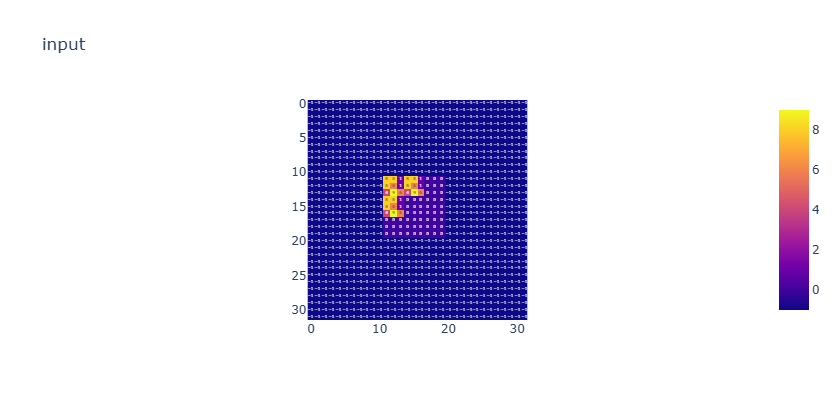

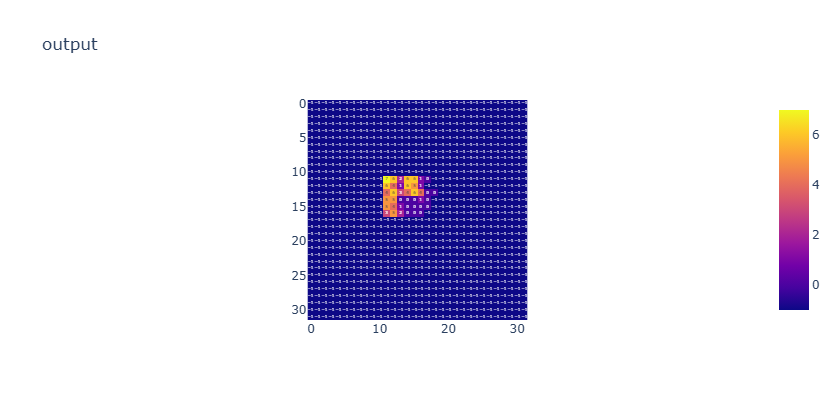

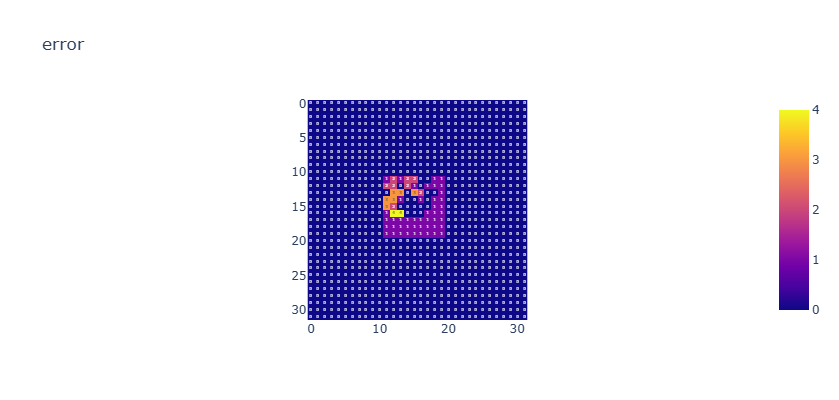

Error stats:
	 Max: 4.0
	 Min: 0.0
	 Avg: 0.0859375


In [12]:
sample_idx = 123
batch_idx = 1
noise_scale = 0.19
denoise_steps = 20
# denoise_steps = checkpoint_config['diffuser']['denoising_steps']

x = dataset[sample_idx][0][batch_idx]

x = x.unsqueeze(dim=0).unsqueeze(dim=1).to(device)

if model_config['backbone'] == 'catunet':
    # x can be considered as mask / magnitude of category `c`
    c = x
    x = torch.where(x >= 0, 1., 0)            
else:
    # normalize num_classes = 10, background = -1
    x = torch.where(x >= 0, x/10, x)

# Add noise
n = (noise_scale * torch.rand(x.shape[0])).to(device)
x_n = noise_schedule(x, n)
x_n = x_n.to(device)

# Predict
with torch.no_grad():
    if model_config['backbone'] == 'catunet':
        x = c
        y = model(x_n, c, t=denoise_steps)
    else:
        y = model(x_n, t=denoise_steps)
        
x = x.squeeze().detach().cpu().numpy()
y = y.squeeze().detach().cpu().numpy()

if model_config['backbone'] != 'catunet':
    x *= 10
    y *= 10

x = np.rint(x)
y = np.rint(y)

x = np.where(x >= 0, x, -1)
y = np.where(y >= 0, y, -1)

e = np.abs(y - x)

plot_trigrids(x, y, e)

print('Error stats:')
print('\t Max:', np.max(e))
print('\t Min:', np.min(e))
print('\t Avg:', np.mean(e))

## <div style="color: #D35142; font-weight: bold; font-size: 100%; text-align :center; padding: 12.0px; background: #ffffff"> Thank you for your reading! </div>
### <div style="color: #D35142; font-weight: bold; font-size: 100%; text-align: center; padding: 12.0px; background: #ffffff"> Please upvote this notebook if you consider it helpful. Your feedback is my motivation to contribute more ! </div>